# Magic Formula

Backtest da estratégia Magic Formula de Joel Greenblatt  
link: https://www.amazon.com.br/F%C3%B3rmula-M%C3%A1gica-Greenblatt-Bater-Mercado/dp/8557173601

## Coleta e tratamento de dados

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import warnings
from datetime import date
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
import os
warnings.filterwarnings("ignore")

In [4]:
chrome_install = ChromeDriverManager().install()

folder = os.path.dirname(chrome_install)
chromedriver_path = os.path.join(folder, "chromedriver.exe")

service = webdriver.ChromeService(executable_path=chromedriver_path)

driver = webdriver.Chrome(service=service)

driver.get('https://www.fundamentus.com.br/resultado.php')

In [11]:
local_tabela = '/html/body/div[1]/div[2]/table'

tabela = driver.find_element('xpath', local_tabela)

html_tabela = tabela.get_attribute('outerHTML')

tabela = pd.read_html(str(html_tabela), thousands = '.', decimal = ',')[0]

tabela.head()

,Papel,Cotação,P/L,P/VP,PSR,Div.Yield,P/Ativo,P/Cap.Giro,P/EBIT,P/Ativ Circ.Liq,...,EV/EBITDA,Mrg Ebit,Mrg. Líq.,Liq. Corr.,ROIC,ROE,Liq.2meses,Patrim. Líq,Dív.Brut/ Patrim.,Cresc. Rec.5a
0,IVTT3,0.00,0.0,0.0,0.0,"0,00%",0.0,0.0,0.0,0.0,...,0.0,"0,00%","0,00%",0.00,"0,00%","-0,40%",0.0,1.083050e+09,0.00,"20,67%"
1,MNSA4,0.47,0.0,0.0,0.0,"0,00%",0.0,0.0,0.0,0.0,...,0.0,"-208,15%","-362,66%",3.63,"-13,50%","145,70%",0.0,-9.105000e+06,-6.52,"-41,11%"
2,MNSA3,0.42,0.0,0.0,0.0,"0,00%",0.0,0.0,0.0,0.0,...,0.0,"-208,15%","-362,66%",3.63,"-13,50%","145,70%",0.0,-9.105000e+06,-6.52,"-41,11%"
3,PORP4,2.40,0.0,0.0,0.0,"0,00%",0.0,0.0,0.0,0.0,...,0.0,"0,00%","0,00%",0.00,"0,00%","-2,08%",0.0,2.239900e+07,0.00,"13,66%"
4,POPR4,10.17,0.0,0.0,0.0,"0,00%",0.0,0.0,0.0,0.0,...,0.0,"8,66%","5,65%",1.08,"15,25%","19,93%",0.0,5.458030e+08,0.82,"30,93%"


In [12]:
tabela = tabela.set_index('Papel')
tabela = tabela[['Cotação', 'P/L', 'EV/EBIT', 'ROIC', 'Liq.2meses']]
tabela.head()

,Cotação,P/L,EV/EBIT,ROIC,Liq.2meses
Papel,,,,,
IVTT3,0.00,0.0,0.0,"0,00%",0.0
MNSA4,0.47,0.0,0.0,"-13,50%",0.0
MNSA3,0.42,0.0,0.0,"-13,50%",0.0
PORP4,2.40,0.0,0.0,"0,00%",0.0
POPR4,10.17,0.0,0.0,"15,25%",0.0


In [13]:
tabela['ROIC'] = tabela['ROIC'].str.replace('%', '')
tabela['ROIC'] = tabela['ROIC'].str.replace('.', '')
tabela['ROIC'] = tabela['ROIC'].str.replace(',', '.')
tabela['ROIC'] = tabela['ROIC'].astype(float)
tabela.head()

,Cotação,P/L,EV/EBIT,ROIC,Liq.2meses
Papel,,,,,
IVTT3,0.00,0.0,0.0,0.00,0.0
MNSA4,0.47,0.0,0.0,-13.50,0.0
MNSA3,0.42,0.0,0.0,-13.50,0.0
PORP4,2.40,0.0,0.0,0.00,0.0
POPR4,10.17,0.0,0.0,15.25,0.0


In [14]:
tabela = tabela.loc[(tabela['Liq.2meses'] > 1000000) & (tabela['EV/EBIT'] > 0) & (tabela['ROIC'] > 0) & (tabela['P/L'] > 0)]

tabela.head()

,Cotação,P/L,EV/EBIT,ROIC,Liq.2meses
Papel,,,,,
AZUL4,0.66,0.05,7.48,22.22,33642000.0
LIGT3,6.11,0.94,4.48,9.21,8607820.0
SYNE3,6.50,1.78,2.96,17.26,3099670.0
JBSS3,39.03,3.11,4.58,14.70,260464000.0
JHSF3,5.03,3.21,10.98,4.81,14265400.0


In [16]:
# Ranking por ROIC e P/L

tabela['ranking_roic'] = tabela['ROIC'].rank(ascending=False)
tabela['ranking_ev_ebit'] = tabela['EV/EBIT'].rank(ascending=True)
tabela['ranking_final'] = tabela['ranking_roic'] + tabela['ranking_ev_ebit']

tabela.sort_values('ranking_final').head(15)

,Cotação,P/L,EV/EBIT,ROIC,Liq.2meses,ranking_ev_ebit,ranking_roic,ranking_final
Papel,,,,,,,,
PSSA3,51.60,11.81,0.79,75.11,1.084550e+08,1.0,1.0,2.0
WIZC3,7.20,6.80,1.71,33.58,3.256510e+06,2.0,6.0,8.0
PLPL3,13.25,7.32,3.88,45.75,1.380540e+07,8.0,2.0,10.0
NATU3,9.14,13.67,3.90,24.75,1.841650e+07,9.0,13.0,22.0
PETR4,31.35,8.40,3.47,19.61,1.078980e+09,6.0,24.5,30.5
PETR3,34.08,9.13,3.64,19.61,3.519660e+08,7.0,24.5,31.5
CMIN3,5.33,8.09,4.93,26.14,3.164800e+07,21.0,11.0,32.0
QUAL3,1.65,124.40,2.55,18.47,3.403260e+06,3.0,29.0,32.0
LEVE3,28.18,7.64,5.51,34.75,7.738680e+06,28.0,5.0,33.0


In [18]:
tabela['ranking_pl'] = tabela['P/L'].rank(ascending=True)
tabela['ranking_alternativo'] = tabela['ranking_roic'] + tabela['ranking_pl']

tabela.sort_values('ranking_alternativo')[0:10]

,Cotação,P/L,EV/EBIT,ROIC,Liq.2meses,ranking_ev_ebit,ranking_roic,ranking_final,ranking_pl,ranking_alternativo
Papel,,,,,,,,,,
AZUL4,0.66,0.05,7.48,22.22,33642000.0,65.0,16.0,81.0,1.0,17.0
SYNE3,6.50,1.78,2.96,17.26,3099670.0,5.0,31.0,36.0,3.0,34.0
WIZC3,7.20,6.80,1.71,33.58,3256510.0,2.0,6.0,8.0,34.5,40.5
PLPL3,13.25,7.32,3.88,45.75,13805400.0,8.0,2.0,10.0,41.0,43.0
JBSS3,39.03,3.11,4.58,14.70,260464000.0,15.0,44.0,59.0,4.0,48.0
VLID3,22.11,5.90,4.65,17.87,7299900.0,18.0,30.0,48.0,22.0,52.0
POMO3,6.54,6.56,6.50,20.54,1393110.0,53.0,21.5,74.5,30.5,52.0
LEVE3,28.18,7.64,5.51,34.75,7738680.0,28.0,5.0,33.0,48.5,53.5
VTRU3,8.71,3.53,4.08,14.15,6194620.0,10.0,47.0,57.0,7.0,54.0


## Backtest Magic Formula

### Estratégia Magic Formula

In [20]:
estrategia_1 = tabela.sort_values('ranking_final')[0:10].index

ativos = [x + '.SA' for x in estrategia_1]

inicio = '2025-01-01'
fim = date.today()

carteira_1 = yf.download(tickers=ativos, start=inicio, end=fim)['Close']

carteira_1.head()

[*********************100%***********************]  10 of 10 completed


Ticker,CMIN3.SA,LEVE3.SA,NATU3.SA,PETR3.SA,PETR4.SA,PLPL3.SA,PSSA3.SA,QUAL3.SA,SYNE3.SA,WIZC3.SA
Date,,,,,,,,,,
2025-01-02,4.799329,25.048725,NaN,38.512573,34.832966,8.230462,35.367054,1.495470,4.866807,5.311537
2025-01-03,4.646969,24.736916,NaN,38.379505,34.463512,8.131083,33.951199,1.495470,5.115678,4.956796
2025-01-06,4.770762,25.162109,NaN,38.018333,34.302467,8.293705,35.318226,1.495470,4.968198,5.052672
2025-01-07,4.587415,25.152662,NaN,39.082848,35.031902,8.356946,36.128685,1.545319,4.912894,5.100610
2025-01-08,4.453055,25.483368,NaN,38.712166,34.747711,8.031703,35.650223,1.555288,4.673241,5.148548


<Axes: xlabel='Date'>

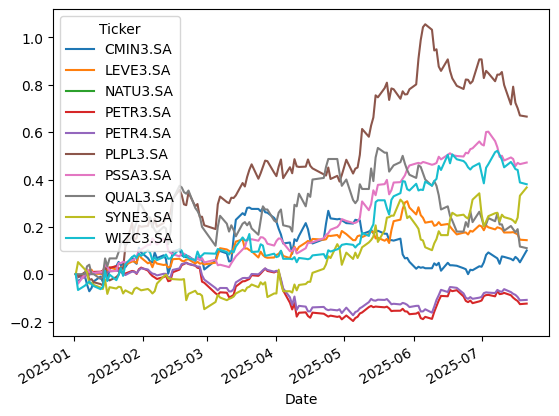

In [ ]:
# Retorno individual no período

(carteira_1/carteira_1.iloc[0] - 1).plot()

<Axes: xlabel='Date'>

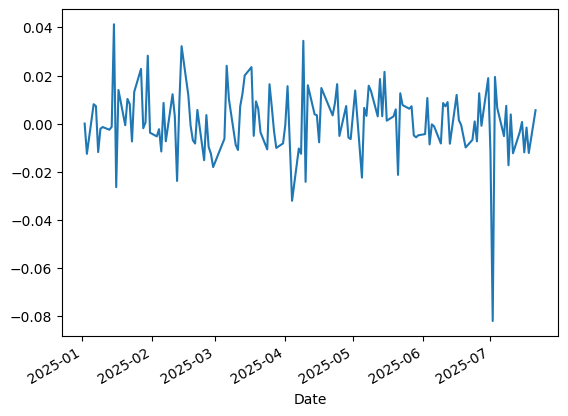

In [24]:
# Retorno diários

pesos = 1/len(ativos)

retornos = carteira_1.pct_change()

retorno_carteira = (retornos*pesos).sum(axis=1)

retorno_carteira.plot()

<Axes: xlabel='Date'>

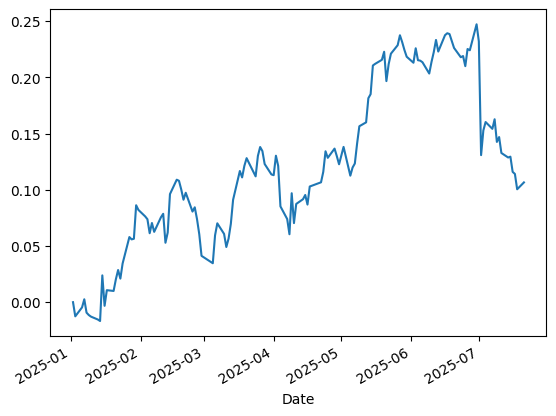

In [ ]:
# Retorno Acumulado Carteira
retorno_acum_carteira = (1 + retorno_carteira).cumprod() - 1

retorno_acum_carteira.plot()

### Estratégia Alternativa
Usando P/L ao invés de EV/EBIT

In [30]:
estrategia_2 = tabela.sort_values('ranking_alternativo')[0:10].index

ativos_2 = [x + '.SA' for x in estrategia_2]

inicio = '2025-01-01'
fim = date.today()

carteira_2 = yf.download(tickers=ativos_2, start=inicio, end=fim)['Close']

carteira_2.head()

[*********************100%***********************]  10 of 10 completed


Ticker,AZUL4.SA,JBSS3.SA,LEVE3.SA,PLPL3.SA,POMO3.SA,SBSP3.SA,SYNE3.SA,VLID3.SA,VTRU3.SA,WIZC3.SA
Date,,,,,,,,,,
2025-01-02,3.64,37.099998,25.048725,8.230462,5.513980,85.598137,4.866807,20.101427,6.391921,5.311537
2025-01-03,3.75,36.330002,24.736916,8.131083,5.362652,84.088776,5.115678,23.373753,6.052880,4.956796
2025-01-06,4.30,36.389999,25.162109,8.293705,5.324821,85.211121,4.968198,22.831482,6.481668,5.052672
2025-01-07,4.20,35.830002,25.152662,8.356946,5.485606,86.343140,4.912894,21.877832,6.691075,5.100610
2025-01-08,4.21,35.619999,25.483368,8.031703,5.258615,84.272606,4.673241,22.177015,6.322119,5.148548


<Axes: xlabel='Date'>

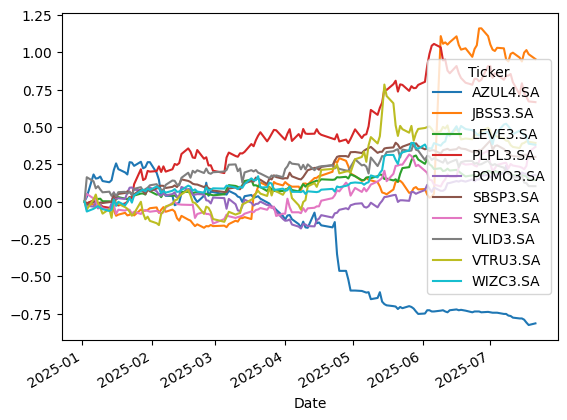

In [31]:
# Retorno individual no período

(carteira_2/carteira_2.iloc[0] - 1).plot()

<Axes: xlabel='Date'>

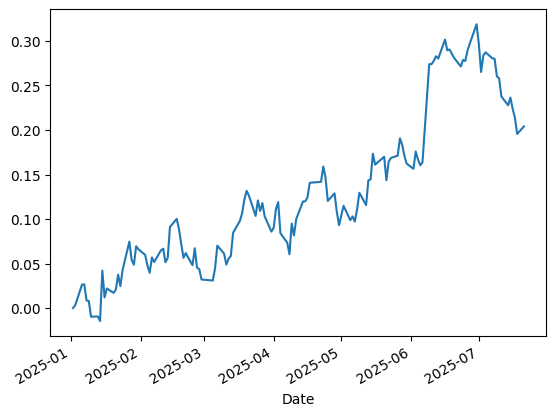

In [33]:
# Retorno Acumulado Carteira

pesos = 1/len(ativos_2)

retornos_2 = carteira_2.pct_change()

retorno_carteira_2 = (retornos_2*pesos).sum(axis=1)

retorno_acum_carteira_2 = (1 + retorno_carteira_2).cumprod() - 1

retorno_acum_carteira_2.plot()

## Comparativo IBOVESPA

[*********************100%***********************]  1 of 1 completed

<Axes: xlabel='Date'>

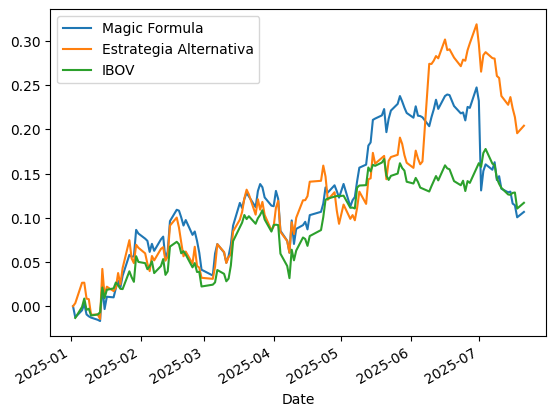

In [36]:
ibov = yf.download('^BVSP', start=inicio, end=fim)['Close']

retorno_ibov = ibov.pct_change()

retorno_acumulado_ibov = (1 + retorno_ibov).cumprod() - 1

retorno_portfolio = pd.DataFrame()
retorno_portfolio['Magic Formula'] = retorno_acum_carteira
retorno_portfolio['Estrategia Alternativa'] = retorno_acum_carteira_2
retorno_portfolio['IBOV'] = retorno_acumulado_ibov

retorno_portfolio.plot()

In [37]:
retorno_portfolio.tail()

,Magic Formula,Estrategia Alternativa,IBOV
Date,,,
2025-07-15,0.129527,0.236433,0.125911
2025-07-16,0.115986,0.223705,0.128083
2025-07-17,0.114137,0.213804,0.128533
2025-07-18,0.100491,0.195529,0.110360
2025-07-21,0.106595,0.204053,0.116895
